In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import itertools

In [2]:
train = pd.read_csv('../data/train_mod.csv',index_col='id', parse_dates=['timestamp'])
#test = pd.read_csv('data/test_mod.csv',index_col='id', parse_dates=['timestamp'])

Find the columns that have no missing data and the converse columns. 

In [3]:
column_atts = train.isnull().apply(any, axis=0).reset_index()
column_atts.columns = ['name','contains_nan']
full_vars = column_atts.loc[column_atts['contains_nan']==False,'name']
sparse_vars = column_atts.loc[column_atts['contains_nan']==True,'name']

Find the percentage missing of each of these columns

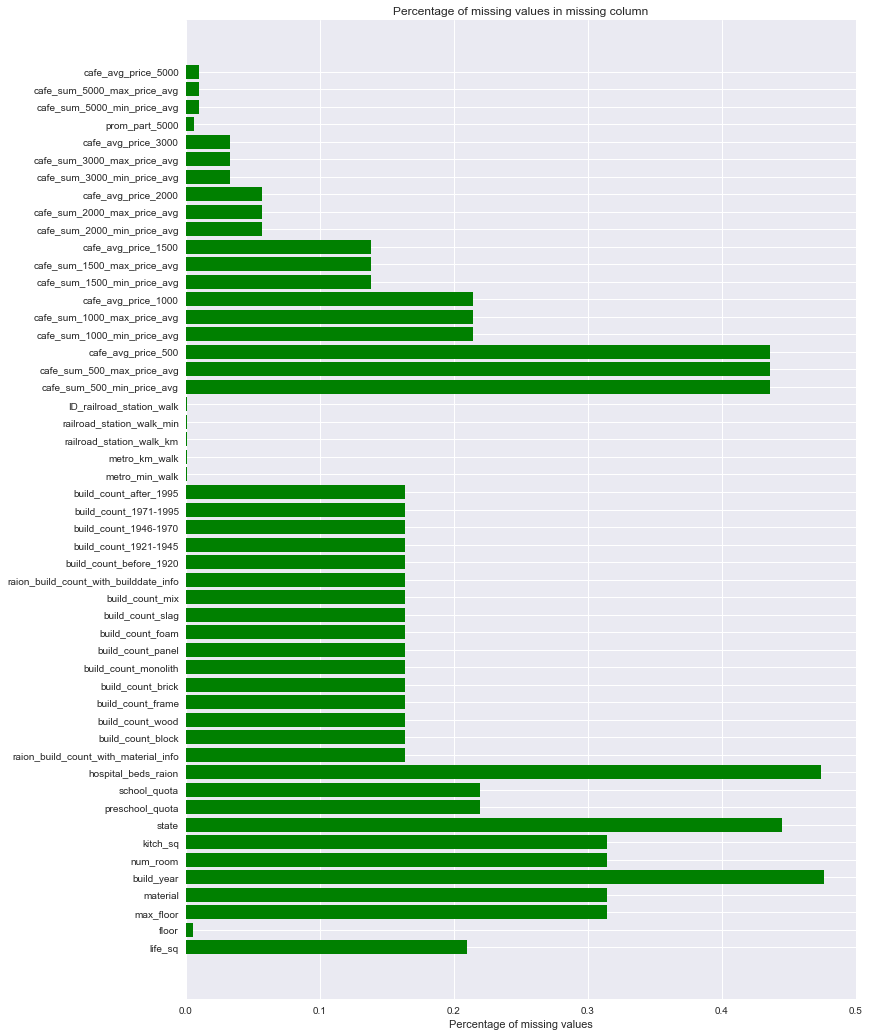

""


In [4]:
missing_df = train[sparse_vars].isnull().sum(axis=0)/train.shape[0]
missing_df = missing_df.reset_index()
missing_df.columns = ['name', 'percent_missing']
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.percent_missing.values, color='g')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.name.values, rotation='horizontal')
ax.set_xlabel("Percentage of missing values")
ax.set_title("Percentage of missing values in missing column")
plt.grid(True)
plt.show()
pd.DataFrame()

sq_metr is a manufactured variable
I'll look at some of the data with very little missing values

In [5]:
barely_missing_names = missing_df[missing_df.percent_missing < 0.001].name.values
BM = train[barely_missing_names]

In [6]:
BM.isnull().sum(0)

metro_min_walk               25
metro_km_walk                25
railroad_station_walk_km     25
railroad_station_walk_min    25
ID_railroad_station_walk     25
dtype: int64

These variables all have the same number of missing values. I wonder if they are in the same rows

In [7]:
inds = np.where(BM.iloc[:,0].isnull())[0]
# Equivalent way
#inds = pd.isnull(barely_missing).any(1).nonzero()[0]

In [8]:
BM.iloc[inds,:]

,metro_min_walk,metro_km_walk,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk
id,,,,,
10712,NaN,NaN,NaN,NaN,NaN
13262,NaN,NaN,NaN,NaN,NaN
13702,NaN,NaN,NaN,NaN,NaN
14799,NaN,NaN,NaN,NaN,NaN
15793,NaN,NaN,NaN,NaN,NaN
17361,NaN,NaN,NaN,NaN,NaN
18258,NaN,NaN,NaN,NaN,NaN
19347,NaN,NaN,NaN,NaN,NaN
19373,NaN,NaN,NaN,NaN,NaN


Yes they're all in the same rows. What do these values look like in general?

In [9]:
BM.loc[BM.railroad_station_walk_km > 1].loc[BM.railroad_station_walk_km < 1.5].head()

,metro_min_walk,metro_km_walk,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk
id,,,,,
3,17.351515,1.445960,1.277658,15.331896,3.0
14,14.576476,1.214706,1.254206,15.050477,14.0
28,13.119129,1.093261,1.073578,12.882934,24.0
37,8.176095,0.681341,1.180346,14.164153,17.0
39,13.135947,1.094662,1.196604,14.359246,30.0


Scatter plot of min_walk versus km_walk

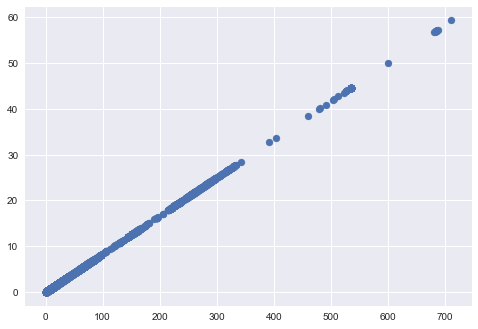

In [10]:
plt.scatter(BM.metro_min_walk,BM.metro_km_walk)

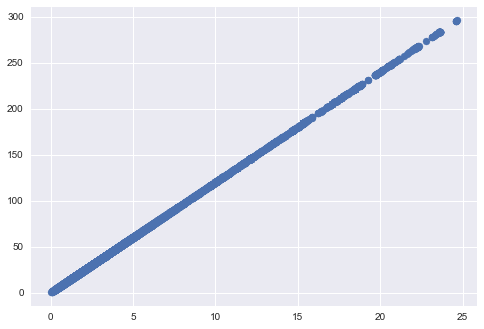

In [11]:
plt.scatter(BM.railroad_station_walk_km, BM.railroad_station_walk_min)

Linearly dependent so one can be dropped. There are a few other variables like this. Just to make sure I will plot them all. 

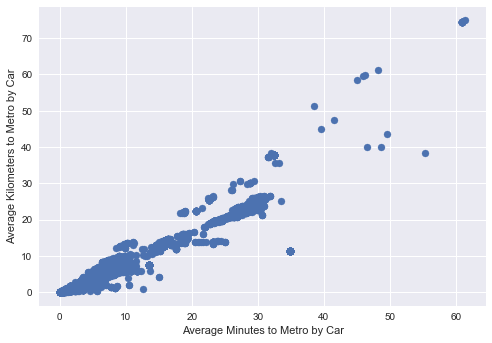

In [12]:
plt.scatter(train.metro_min_avto, train.metro_km_avto)
plt.xlabel('Average Minutes to Metro by Car')
plt.ylabel('Average Kilometers to Metro by Car')

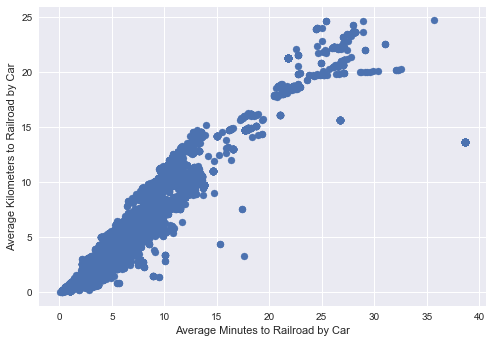

In [13]:
plt.scatter(train.railroad_station_avto_min, train.railroad_station_avto_km)
plt.xlabel('Average Minutes to Railroad by Car')
plt.ylabel('Average Kilometers to Railroad by Car')

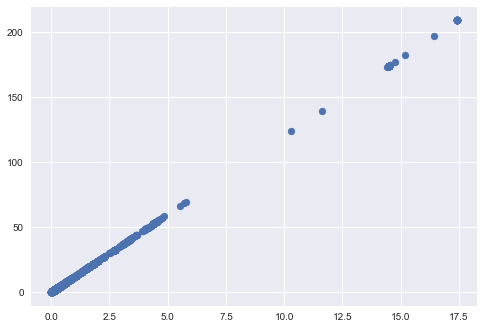

In [14]:
plt.scatter(train.public_transport_station_km, train.public_transport_station_min_walk)

I'm going to find all the variables with km in their column name and amass them to look at the correlations

In [18]:
cols = list(train.columns)                                                                                                                              
regex = re.compile('.*km.*|.*walk.*|.*raion.*')                                                                                                                            
matching_cols = []                                                                                                                                      
for i in cols:                                                                                                                                          
    s = regex.findall(i)                                                                                                                                
    if len(s) != 0:                                                                                                                                     
        matching_cols.append(s)                                                                                                                         
                                                                                                                                                        
# Flatten the list                                                                                                                                      
matching_cols = list(itertools.chain.from_iterable(matching_cols)) 

In [20]:
len(matching_cols)

79

In [23]:
def corr_plot(data):
    corrmtx = data.corr()
    g = sns.clustermap(corrmtx, annot=True, linewidths=.5)
    for i, ax in enumerate(g.fig.axes):   ## getting all axes of the fig object
        ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)


In [21]:
sec1 = matching_cols[:20]
sec2 = matching_cols[20:40]
sec3 = matching_cols[40:60]
sec4 = matching_cols[60:]

/home/mes/venv/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


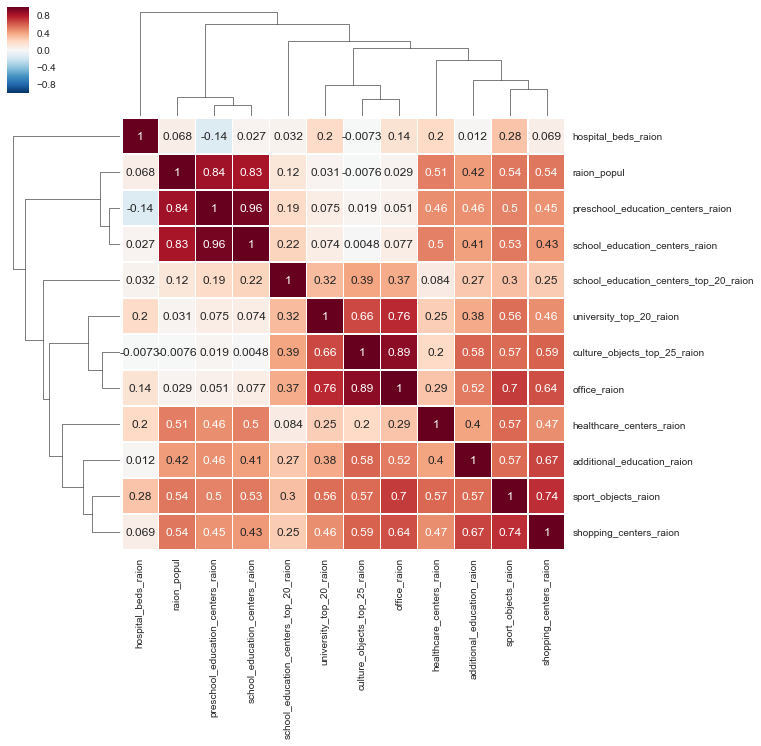

In [24]:
corr_plot(train[sec1])

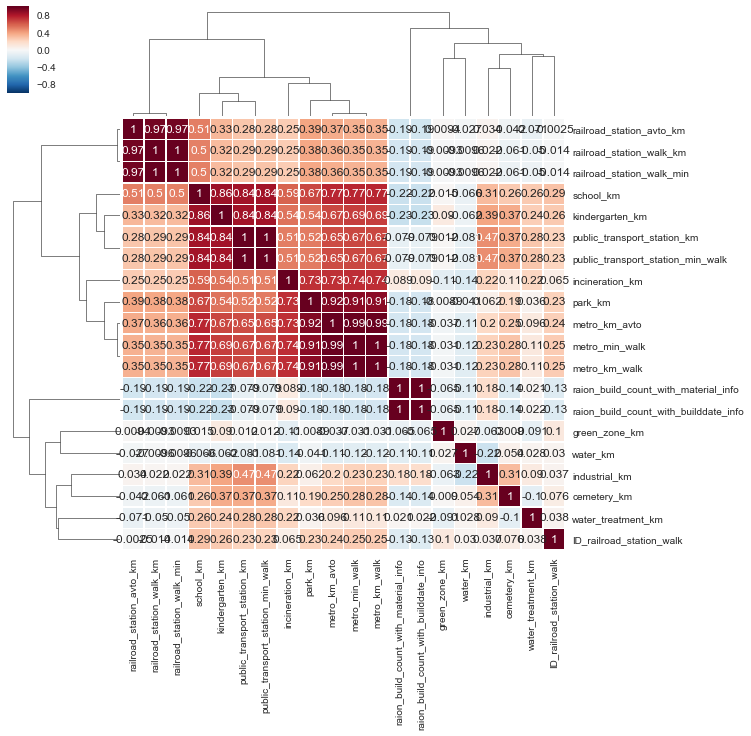

In [25]:
corr_plot(train[sec2])

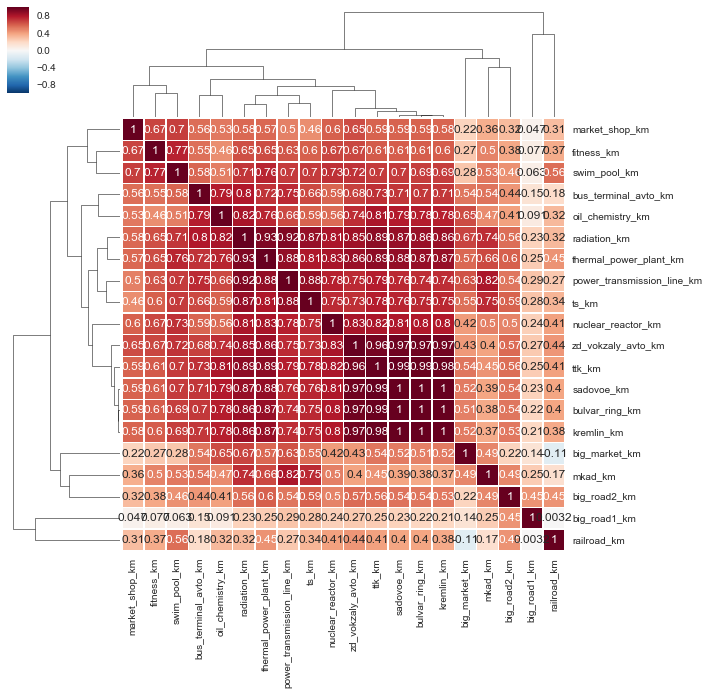

In [26]:
corr_plot(train[sec3])

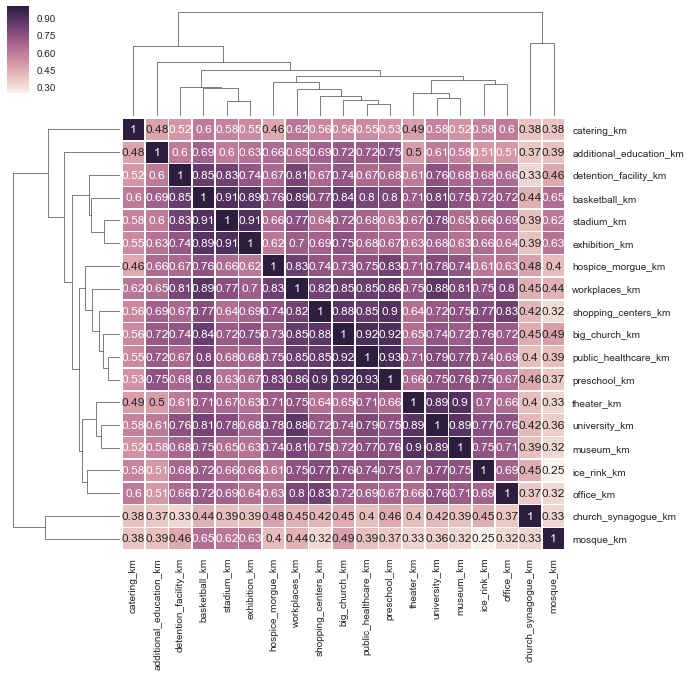

In [27]:
corr_plot(train[sec4])

In [29]:
np.corrcoef(train['metro_min_avto'],train['metro_km_avto'])

array([[ 1.        ,  0.94503491],
       [ 0.94503491,  1.        ]])

## How to deal with all these correlated variables?
    - Should they be dropped?
    - Ideally better understand dimensionality reduction
        - PCA (Principal Component Analysis)